In [ ]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [ ]:
!unzip -q '/content/drive/MyDrive/BTP/dataset.zip' -d '/content'

In [ ]:
data_dir = '/content/dataset'
train_dir = data_dir + '/train'
test_dir = data_dir + '/test'
valid_dir = data_dir + '/valid'

In [ ]:
import tensorflow
from tensorflow import keras
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.efficientnet_v2 import EfficientNetV2S
from tensorflow.keras.applications.efficientnet_v2 import EfficientNetV2S
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
from tensorflow.keras.applications.efficientnet_v2 import preprocess_input, decode_predictions
from keras.utils.np_utils import to_categorical
import numpy as np
import os, shutil
from keras.models import Sequential,load_model,Model
from keras.layers import Conv2D,MaxPool2D,AveragePooling2D,Dense,Flatten,ZeroPadding2D,BatchNormalization,Activation,Add,Input,Dropout,GlobalAveragePooling2D
from keras.initializers import glorot_uniform
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint,EarlyStopping,ReduceLROnPlateau

In [ ]:
ls -a "/content/dataset/valid"

./  ../  .DS_Store  fake/  real/


In [ ]:
!rm -r "/content/dataset/valid/.DS_Store/"

rm: cannot remove '/content/dataset/valid/.DS_Store/': Not a directory


In [ ]:
train_datagen = ImageDataGenerator()

train = train_datagen.flow_from_directory(directory=train_dir,batch_size=128,target_size=(32,32),
                                         color_mode='rgb',class_mode='categorical',seed=42)

val_datagen = ImageDataGenerator()

valid = val_datagen.flow_from_directory(directory=valid_dir,batch_size=128,target_size=(32,32),color_mode='rgb',class_mode='categorical')

test_datagen = ImageDataGenerator()

test = test_datagen.flow_from_directory(directory=test_dir,batch_size=128,target_size=(32,32),color_mode='rgb',class_mode='categorical')

x_train=np.concatenate([train.next()[0] for i in range(train.__len__())])
y_train=np.concatenate([train.next()[1] for i in range(train.__len__())])

x_valid=np.concatenate([valid.next()[0] for i in range(valid.__len__())])
y_valid=np.concatenate([valid.next()[1] for i in range(valid.__len__())])

x_test=np.concatenate([test.next()[0] for i in range(test.__len__())])
y_test=np.concatenate([test.next()[1] for i in range(test.__len__())])

Found 12771 images belonging to 2 classes.
Found 3191 images belonging to 2 classes.
Found 3998 images belonging to 2 classes.


VGG-16

In [ ]:
base_model_tf=VGG16(include_top=False,weights='imagenet',input_shape=(224,224,3),classes=2)

58900480/58889256 [==============================] - 0s 0us/step


In [ ]:
base_model_tf.trainable=False

pt=Input(shape=(224,224,3))
func=tensorflow.cast(pt,tensorflow.float32)
x=preprocess_input(func) 
model_effnet = base_model_tf(x,training=False)
model_effnet = GlobalAveragePooling2D()(model_effnet)
model_effnet = Dense(128,activation='relu')(model_effnet)
model_effnet = Dense(64,activation='relu')(model_effnet)
model_effnet = Dense(2,activation='softmax')(model_effnet)


model_main = Model(inputs=pt,outputs=model_effnet)
model_main.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.cast (TFOpLambda)        (None, 224, 224, 3)       0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 128)               65664     
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                             

In [ ]:
es=EarlyStopping(monitor='accuracy',verbose=1,patience=5,mode='auto')
mc=ModelCheckpoint(filepath='/content',monitor='val_accuracy',verbose=1,save_best_only=True)
lr=ReduceLROnPlateau(monitor='val_accuracy',verbose=1,patience=3,min_lr=0.001)

In [ ]:
model_main.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [ ]:
model_main.fit(train,validation_data=valid,epochs=20,steps_per_epoch=100,verbose=1,callbacks=[es, lr])

NameError: ignored

In [ ]:
model_main.save("/content/drive/MyDrive/BTP/Currency_Detection-Models/VGG16.h5")

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
from PIL import Image

Text(0.5, 1.0, 'model loss')

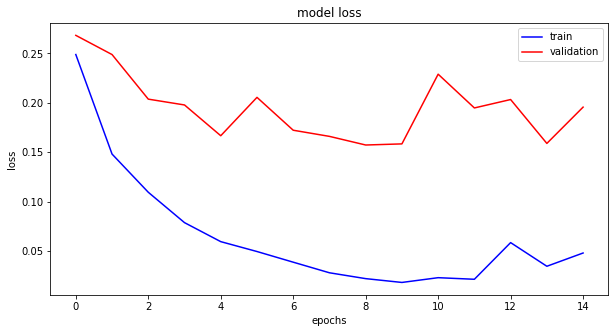

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(model_main.history.history['loss'],color='b',label='Training loss')
plt.plot(model_main.history.history['val_loss'],color='r',label='Validation loss')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend(['train', 'validation'], loc='upper right')
plt.title("model loss")

Text(0.5, 1.0, 'model accuracy')

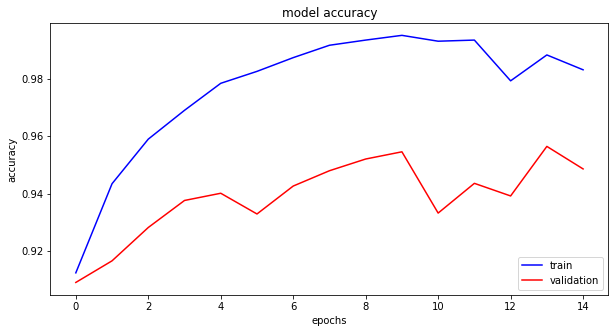

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(model_main.history.history['accuracy'],color='b',label='Training accuracy')
plt.plot(model_main.history.history['val_accuracy'],color='r',label='Validation accsuracy')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.legend(['train', 'validation'], loc='lower right')
plt.title("model accuracy")

In [ ]:
loss, accuracy = model_main.evaluate(train, verbose=1)
print("Trainmodel_main: accuracy = %f  ;  loss = %f" % (accuracy, loss))

loss, accuracy = model_main.evaluate(valid, verbose=1)
print("Validation: accuracy = %f  ;  loss = %f" % (accuracy, loss))

loss, accuracy = model_main.evaluate(test, verbose=1)
print("Test: accuracy = %f  ;  loss = %f" % (accuracy, loss))

100/100 [==============================] - 12s 123ms/step - loss: 0.0475 - accuracy: 0.9834
Trainmodel_main: accuracy = 0.983400  ;  loss = 0.047547
25/25 [==============================] - 4s 150ms/step - loss: 0.1957 - accuracy: 0.9486
Validation: accuracy = 0.948605  ;  loss = 0.195677
32/32 [==============================] - 4s 132ms/step - loss: 0.7729 - accuracy: 0.8474
Test: accuracy = 0.847424  ;  loss = 0.772863


In [ ]:
img = tensorflow.keras.utils.load_img("/content/dataset/test/real/dr_13_1568.jpg",
    target_size=(224, 224, 3)
)
input_arr = tensorflow.keras.preprocessing.image.img_to_array(img)
input_arr = np.array([input_arr])
result = model_main.predict(input_arr)

In [ ]:
probability_model = tensorflow.keras.Sequential([model_main, 
                                         tensorflow.keras.layers.Softmax()])

predict = probability_model.predict(input_arr)

predict[0]

array([0.7208557 , 0.27914435], dtype=float32)

EfficientNetV2S

In [ ]:
base_model_tf=EfficientNetV2S(include_top=False,weights='imagenet',input_shape=(224,224,3),classes=2)

82436096/82420632 [==============================] - 2s 0us/step


In [ ]:
base_model_tf.trainable=False

pt=Input(shape=(224,224,3))
func=tensorflow.cast(pt,tensorflow.float32)
x=preprocess_input(func) 
model_effnet = base_model_tf(x,training=False)
model_effnet = GlobalAveragePooling2D()(model_effnet)
model_effnet = Dense(128,activation='relu')(model_effnet)
model_effnet = Dense(64,activation='relu')(model_effnet)
model_effnet = Dense(2,activation='softmax')(model_effnet)


model_main = Model(inputs=pt,outputs=model_effnet)
model_main.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.cast (TFOpLambda)        (None, 224, 224, 3)       0         
                                                                 
 efficientnetv2-s (Functiona  (None, 7, 7, 1280)       20331360  
 l)                                                              
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 128)               163968    
                                                                 
 dense_1 (Dense)             (None, 64)                8256  

In [ ]:
es=EarlyStopping(monitor='accuracy',verbose=1,patience=5,mode='auto')
mc=ModelCheckpoint(filepath='/content',monitor='val_accuracy',verbose=1,save_best_only=True)
lr=ReduceLROnPlateau(monitor='val_accuracy',verbose=1,patience=3,min_lr=0.001)

In [ ]:
model_main.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [ ]:
model_main.fit(train,validation_data=valid,epochs=50,steps_per_epoch=100,verbose=1,callbacks=[es, lr])

Epoch 1/50
100/100 [==============================] - 88s 744ms/step - loss: 0.6500 - accuracy: 0.6086 - val_loss: 0.5899 - val_accuracy: 0.6797 - lr: 0.0010
Epoch 2/50
100/100 [==============================] - 71s 714ms/step - loss: 0.5628 - accuracy: 0.7086 - val_loss: 0.5887 - val_accuracy: 0.6854 - lr: 0.0010
Epoch 3/50
100/100 [==============================] - 69s 691ms/step - loss: 0.5235 - accuracy: 0.7354 - val_loss: 0.4886 - val_accuracy: 0.7562 - lr: 0.0010
Epoch 4/50
100/100 [==============================] - 69s 689ms/step - loss: 0.4740 - accuracy: 0.7710 - val_loss: 0.4724 - val_accuracy: 0.7753 - lr: 0.0010
Epoch 5/50
100/100 [==============================] - 69s 685ms/step - loss: 0.4439 - accuracy: 0.7903 - val_loss: 0.4912 - val_accuracy: 0.7371 - lr: 0.0010
Epoch 6/50
100/100 [==============================] - 69s 689ms/step - loss: 0.4285 - accuracy: 0.7966 - val_loss: 0.3961 - val_accuracy: 0.8123 - lr: 0.0010
Epoch 7/50
100/100 [==============================] 

In [ ]:
model_main.save("/content/drive/MyDrive/BTP/Currency_Detection-Models/EfficientNetV2S.h5")

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
from PIL import Image

Text(0.5, 1.0, 'model loss')

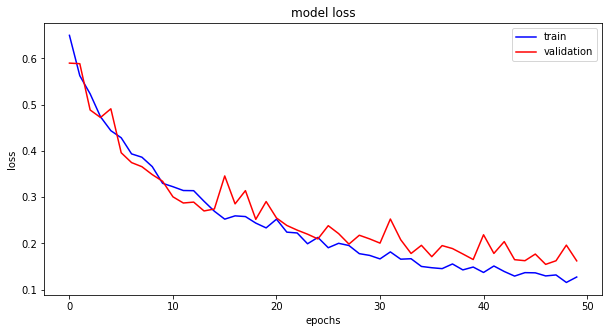

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(model_main.history.history['loss'],color='b',label='Training loss')
plt.plot(model_main.history.history['val_loss'],color='r',label='Validation loss')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend(['train', 'validation'], loc='upper right')
plt.title("model loss")

Text(0.5, 1.0, 'model accuracy')

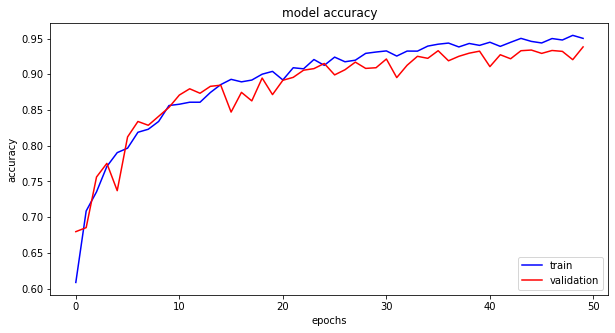

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(model_main.history.history['accuracy'],color='b',label='Training accuracy')
plt.plot(model_main.history.history['val_accuracy'],color='r',label='Validation accsuracy')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.legend(['train', 'validation'], loc='lower right')
plt.title("model accuracy")

In [ ]:
loss, accuracy = model_main.evaluate(train, verbose=1)
print("Trainmodel_main: accuracy = %f  ;  loss = %f" % (accuracy, loss))

loss, accuracy = model_main.evaluate(valid, verbose=1)
print("Validation: accuracy = %f  ;  loss = %f" % (accuracy, loss))

loss, accuracy = model_main.evaluate(test, verbose=1)
print("Test: accuracy = %f  ;  loss = %f" % (accuracy, loss))

100/100 [==============================] - 53s 530ms/step - loss: 0.1014 - accuracy: 0.9620
Trainmodel_main: accuracy = 0.962023  ;  loss = 0.101410
25/25 [==============================] - 13s 525ms/step - loss: 0.1623 - accuracy: 0.9383
Validation: accuracy = 0.938264  ;  loss = 0.162341
32/32 [==============================] - 17s 514ms/step - loss: 0.4227 - accuracy: 0.8529
Test: accuracy = 0.852926  ;  loss = 0.422661


In [ ]:
img = tensorflow.keras.utils.load_img("/content/dataset/test/real/dr_13_1568.jpg",
    target_size=(224, 224, 3)
)
input_arr = tensorflow.keras.preprocessing.image.img_to_array(img)
input_arr = np.array([input_arr])
result = model_main.predict(input_arr)

In [ ]:
probability_model = tensorflow.keras.Sequential([model_main, 
                                         tensorflow.keras.layers.Softmax()])

predict = probability_model.predict(input_arr)

predict[0]

ResNet50

In [ ]:
base_model_tf=ResNet50(include_top=False,weights='imagenet',input_shape=(224,224,3),classes=2)

94781440/94765736 [==============================] - 0s 0us/step


In [ ]:
base_model_tf.trainable=False

pt=Input(shape=(224,224,3))
func=tensorflow.cast(pt,tensorflow.float32)
x=preprocess_input(func) 
model_effnet = base_model_tf(x,training=False)
model_effnet = GlobalAveragePooling2D()(model_effnet)
model_effnet = Dense(128,activation='relu')(model_effnet)
model_effnet = Dense(64,activation='relu')(model_effnet)
model_effnet = Dense(2,activation='softmax')(model_effnet)


model_main = Model(inputs=pt,outputs=model_effnet)
model_main.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.cast_1 (TFOpLambda)      (None, 224, 224, 3)       0         
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 128)               262272    
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                             

In [ ]:
es=EarlyStopping(monitor='accuracy',verbose=1,patience=5,mode='auto')
mc=ModelCheckpoint(filepath='/content',monitor='val_accuracy',verbose=1,save_best_only=True)
lr=ReduceLROnPlateau(monitor='val_accuracy',verbose=1,patience=3,min_lr=0.001)

In [ ]:
model_main.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [ ]:
model_main.fit(train,validation_data=valid,epochs=50,steps_per_epoch=100,verbose=1,callbacks=[es, lr])

Epoch 1/50
100/100 [==============================] - 49s 466ms/step - loss: 0.4541 - accuracy: 0.8017 - val_loss: 0.2710 - val_accuracy: 0.8834 - lr: 0.0010
Epoch 2/50
100/100 [==============================] - 46s 462ms/step - loss: 0.2079 - accuracy: 0.9161 - val_loss: 0.2046 - val_accuracy: 0.9170 - lr: 0.0010
Epoch 3/50
100/100 [==============================] - 46s 456ms/step - loss: 0.1367 - accuracy: 0.9483 - val_loss: 0.1805 - val_accuracy: 0.9282 - lr: 0.0010
Epoch 4/50
100/100 [==============================] - 46s 455ms/step - loss: 0.0996 - accuracy: 0.9610 - val_loss: 0.1611 - val_accuracy: 0.9361 - lr: 0.0010
Epoch 5/50
100/100 [==============================] - 46s 458ms/step - loss: 0.0766 - accuracy: 0.9702 - val_loss: 0.1312 - val_accuracy: 0.9492 - lr: 0.0010
Epoch 6/50
100/100 [==============================] - 48s 476ms/step - loss: 0.0654 - accuracy: 0.9751 - val_loss: 0.1431 - val_accuracy: 0.9502 - lr: 0.0010
Epoch 7/50
100/100 [==============================] 

In [ ]:
model_main.save("/content/drive/MyDrive/BTP/Currency_Detection-Models/ResNet50.h5")

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
from PIL import Image

Text(0.5, 1.0, 'model loss')

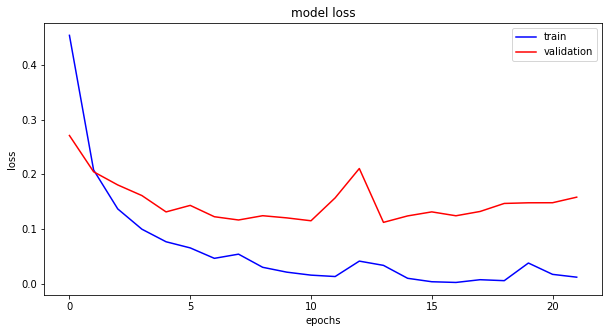

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(model_main.history.history['loss'],color='b',label='Training loss')
plt.plot(model_main.history.history['val_loss'],color='r',label='Validation loss')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend(['train', 'validation'], loc='upper right')
plt.title("model loss")

Text(0.5, 1.0, 'model accuracy')

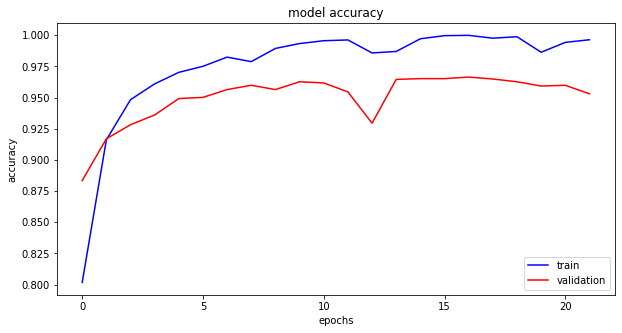

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(model_main.history.history['accuracy'],color='b',label='Training accuracy')
plt.plot(model_main.history.history['val_accuracy'],color='r',label='Validation accsuracy')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.legend(['train', 'validation'], loc='lower right')
plt.title("model accuracy")

In [ ]:
loss, accuracy = model_main.evaluate(train, verbose=1)
print("Trainmodel_main: accuracy = %f  ;  loss = %f" % (accuracy, loss))

loss, accuracy = model_main.evaluate(valid, verbose=1)
print("Validation: accuracy = %f  ;  loss = %f" % (accuracy, loss))

loss, accuracy = model_main.evaluate(test, verbose=1)
print("Test: accuracy = %f  ;  loss = %f" % (accuracy, loss))

100/100 [==============================] - 37s 366ms/step - loss: 0.0178 - accuracy: 0.9937
Trainmodel_main: accuracy = 0.993736  ;  loss = 0.017836
25/25 [==============================] - 9s 357ms/step - loss: 0.1582 - accuracy: 0.9530
Validation: accuracy = 0.952993  ;  loss = 0.158182
32/32 [==============================] - 11s 348ms/step - loss: 0.7121 - accuracy: 0.8762
Test: accuracy = 0.876188  ;  loss = 0.712060


In [ ]:
img = tensorflow.keras.utils.load_img("/content/dataset/test/fake/dr_13_1567.jpg",
    target_size=(224, 224, 3)
)
input_arr = tensorflow.keras.preprocessing.image.img_to_array(img)
input_arr = np.array([input_arr])
result = model_main.predict(input_arr)

In [ ]:
probability_model = tensorflow.keras.Sequential([model_main, 
                                         tensorflow.keras.layers.Softmax()])

predict = probability_model.predict(input_arr)

predict[0]

array([0.63515455, 0.36484548], dtype=float32)

Evaluate

In [ ]:
from tensorflow.keras.models import load_model
model=load_model("/content/drive/MyDrive/BTP/Currency_Detection-Models/EfficientNetV2S.h5")

The given currency is Fake !


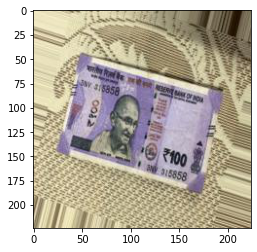

In [ ]:
img = tensorflow.keras.utils.load_img("/content/dataset/test/fake/dr_13_1567.jpg",
    target_size=(224, 224, 3)
)
input_arr = tensorflow.keras.preprocessing.image.img_to_array(img)
input_arr = np.array([input_arr])
result = model.predict(input_arr)
plt.imshow(img)
if result[0][1]>=0.5:
  print("The given currency is Real !")
else:
  print("The given currency is Fake !")